# Data exploration

Let's take a look at the data we got from the Wikipedia CirrusSearch dump. The gzip 'content' file is 34 GB on disk, so I don't think that we want to try decompressing and reading the whole thing into memory unless we have to. Let's see if we can stream the data from the gzip archive and take a look at what we have.

**TLDR**
1. CirrusSearch 'content' dump has text and title keys
2. Reading from decompressed JSON is twice and fast as reading from the gzip archive

## 1. Run set-up

In [1]:
# Change working directory to parent so we can import as we would from __main__.py
print(f'Working directory: ', end = '')
%cd ..

# Standard imports
import json
import time
import numpy as np
from gzip import GzipFile

# PyPI imports
import mwparserfromhell
import matplotlib.pyplot as plt # type: ignore

# Internal imports
import functions.notebook_helper as helper_funcs

Working directory: /mnt/arkk/opensearch/semantic_search


In [2]:
# Input data filepaths
gzip_data_file_path='./data/raw_data/enwiki-20240930-cirrussearch-content.json.gz'
json_data_file_path='./data/raw_data/enwiki-20240930-cirrussearch-content.json'

# Number of records to load for inspection
sample_records=5

# Turn experiments on or off
run_full_read=False
run_rate_experiments=True
run_parse_experiments=True

# Run replicates of chunks and use the mean rates to estimate the total read times
read_time_estimate_replicates=100
read_time_estimate_chunk_size=500

## 2. Inspect sample record

In [3]:
# Load a few records for inspection
file_stream=GzipFile(gzip_data_file_path)
records = []

for i in range(sample_records):

    line=next(file_stream)
    record=json.loads(line)
    records.append(record)

print(f'Loaded {len(records)} records from gzip archive.')
print(f'Record is: {type(records[0])}')

print(f'\nRecord 0 contains:')

for key, value in records[0].items():
    print(f' {key}: {value}')


Loaded 5 records from gzip archive.
Record is: <class 'dict'>

Record 0 contains:
 index: {'_type': '_doc', '_id': '1000'}


OK, looks like the first line in the file is just some metadata. Let's look at the second record.

In [4]:
print(f'\nRecord 1 keys:')

for key in records[1].keys():
    print(f' {key}')


Record 1 keys:
 version
 wiki
 page_id
 namespace
 namespace_text
 title
 timestamp
 create_timestamp
 redirect
 category
 external_link
 outgoing_link
 template
 text
 source_text
 text_bytes
 content_model
 coordinates
 language
 heading
 opening_text
 auxiliary_text
 defaultsort
 file_text
 display_title
 wikibase_item
 popularity_score
 weighted_tags


More like what we were expecting. We have keys for title, text, timestamp, language, even popularity score? Didn't know Wikipedia had that. Here is the title and some text from the first record:

In [5]:
start_text=' '.join(records[1]['text'].split(' ')[:100])
end_text=' '.join(records[1]['text'].split(' ')[-100:])

print(f"Title: {records[1]['title']}")
print(f"Text:\n{start_text}\n...\n{end_text}")

Title: Hercule Poirot
Text:
Hercule Poirot (UK: /ˈɛərkjuːl ˈpwɑːroʊ/, US: /hɜːrˈkjuːl pwɑːˈroʊ/) is a fictional Belgian detective created by British writer Agatha Christie. Poirot is one of Christie's most famous and long-running characters, appearing in 33 novels, two plays (Black Coffee and Alibi), and 51 short stories published between 1920 and 1975. Poirot has been portrayed on radio, in film and on television by various actors, including Austin Trevor, John Moffatt, Albert Finney, Peter Ustinov, Ian Holm, Tony Randall, Alfred Molina, Orson Welles, David Suchet, Kenneth Branagh, and John Malkovich. Poirot's name was derived from two other fictional detectives of the time: Marie Belloc
...
Christie, London: Collins Vermandere, Martine (2016). "Case closed? De speurtocht naar de inspiratie voor Agatha Christie's Hercule Poirot" [Case closed? The search for the inspiration for Agatha Christie's Hercule Poirot]. Brood & Rozen (in Dutch). 21 (1). doi:10.21825/br.v21i1.9945. hdl:1854/LU-

Yep, that's a Wikipedia article. Good, I think we can work with this.

## 3. Record read rate: gzip vs JSON
Since the unzipped files are too big to fit in memory, let's first see if there is any time benefit to streaming the data from the gzip archive vs the decompressed JSON file. We have two ways we can read the data:

1. From the gzip archive
2. From the decompressed JSON

Which one is faster? By how much? There is obviously an advantage to reading straight from the archive. Let's read a bunch of records and time it.

### 3.1. Dataset size

First, read all the data through once to determine how many records we have:

In [6]:
%%time

if run_full_read is True:

    # Open the JSON file
    with open(json_data_file_path, 'r') as file:

        # Always skip the first metadata line
        _=next(file)
        
        # Iterate over the lines
        for record_count, line in enumerate(file):

            # Print a status update every 1000 lines
            if record_count % 1000 == 0:
                print(f'Read {record_count} lines', end= '\r')

else:
    # Total record count determined from prior full read
    record_count=13778448

print(f'{record_count} lines total\n')

13778448 lines total

CPU times: user 106 μs, sys: 8 μs, total: 114 μs
Wall time: 123 μs


### 3.2. Gzip archive read rate

In [7]:
%%time

if run_rate_experiments is True:

    # Collect the read rate in records per second for each chunk
    gzip_read_rates=[]

    # Open gzip JSON lines file stream
    file=GzipFile(gzip_data_file_path)

    # Loop on replicates
    while len(gzip_read_rates) < read_time_estimate_replicates:

        # Time how long it takes to load each chunk of records
        start_time=time.time()

        for i in range(read_time_estimate_chunk_size):
            line=next(file)
        
        dT=time.time() - start_time
        gzip_read_rates.append(read_time_estimate_chunk_size / dT)

    # Print the result
    mean_gzip_read_rate=sum(gzip_read_rates) / len(gzip_read_rates)
    print(f'Mean gzip read rate: {mean_gzip_read_rate:.0f} records per second\n')

Mean gzip read rate: 10522 records per second

CPU times: user 4.68 s, sys: 157 ms, total: 4.84 s
Wall time: 4.84 s


### 3.3. JSON read rate

In [8]:
%%time

if run_rate_experiments is True:

    # Collect the read rate in records per second for each chunk
    json_read_rates=[]

    # Open the JSON file
    with open(json_data_file_path, 'r') as file:

        # Loop on replicates
        while len(json_read_rates) < read_time_estimate_replicates:

            # Time how long it takes to load each chunk of records
            start_time=time.time()

            for i in range(read_time_estimate_chunk_size):
                line=next(file)
            
            dT=time.time() - start_time
            json_read_rates.append(read_time_estimate_chunk_size / dT)

    # Print the result
    mean_json_read_rate=sum(json_read_rates) / len(json_read_rates)
    print(f'Mean JSON read rate: {mean_json_read_rate:.0f} records per second\n')

Mean JSON read rate: 68296 records per second

CPU times: user 398 ms, sys: 319 ms, total: 717 ms
Wall time: 756 ms


### 3.4. Read rate results

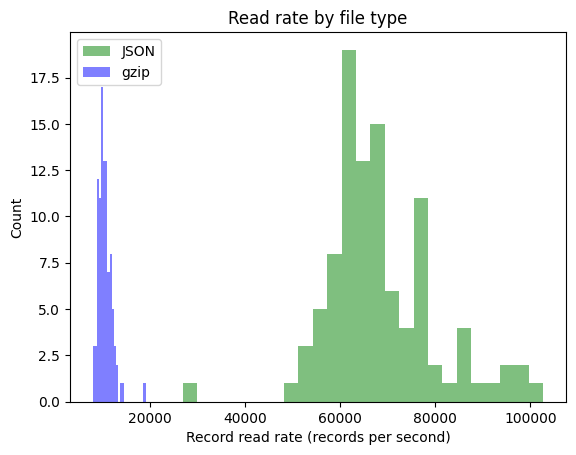


Total gzip read time: 22 minutes
Total JSON read time: 3 minutes


In [9]:
if run_rate_experiments is True:

    plt.title('Read rate by file type')

    plt.hist(
        json_read_rates,
        facecolor='green',
        label='JSON',
        alpha=0.5,
        bins=25
    )

    plt.hist(
        gzip_read_rates,
        facecolor='blue',
        label='gzip',
        alpha=0.5,
        bins=25
    )

    plt.legend(loc = 'upper left')
    plt.xlabel(f'Record read rate (records per second)')
    plt.ylabel('Count')
    plt.show()

    print(f'\nTotal gzip read time: {((record_count / mean_gzip_read_rate) / 60):.0f} minutes')
    print(f'Total JSON read time: {((record_count / mean_json_read_rate) / 60):.0f} minutes')

Reading from the decompressed file is a little less than twice as fast as reading from the gzip archive. Good news is, both are fast enough to be manageable considering the fact that we really only have to read the data from the stream once.

## 4. Record parse rate

In [10]:
%%time

if run_rate_experiments is True:

    # Count line numbers so we can skip odd numbered metadata lines
    line_number=0

    # Count any key errors we might encounter
    keyerror_count=0

    # Collect the read rate in records per second for each chunk
    parse_rates=[]

    # Open the JSON file
    with open(json_data_file_path, 'r') as file:

        # Loop on replicates
        while len(parse_rates) < read_time_estimate_replicates:

            # Time how long it takes to load each chunk of records
            start_time=time.time()

            for i in range(read_time_estimate_chunk_size):

                # Get the next line from the stream
                line=next(file)

                # Skip odd numbered metadata lines
                if line_number % 2 != 0:

                    # Decode the JSON line to a dictionary
                    record=json.loads(line)

                    # Get the text from the record, catching key error
                    # in case this record doesn't have text for some reason
                    try:

                        # Only parse namespace 0 articles
                        if record['namespace'] == 0:

                            text=record['text']

                    except KeyError as e:
                        keyerror_count+=1

                line_number+=1
            
            # Get and save the mean parse rate for this replicate
            dT=time.time() - start_time
            parse_rates.append(read_time_estimate_chunk_size / dT)

    # Print the result
    mean_parse_rate=(sum(parse_rates) / len(parse_rates))
    print(f'Total parse time: {((record_count / mean_parse_rate) / 60):.0f} minutes')
    print(f'Mean parse rate: {mean_parse_rate:.0f} records per second')
    print(f'Encountered {keyerror_count} key errors\n')

Total parse time: 20 minutes
Mean parse rate: 11566 records per second
Encountered 0 key errors

CPU times: user 4.01 s, sys: 344 ms, total: 4.36 s
Wall time: 4.36 s


Not terrible, actually loading the text from each record slows us down by a factor of 8.5. But the total time is still manageable, at least for reading from uncompressed JSON. Reading from the gzip archive directly is going to start taking hours and is probably not a good idea.

## 6. Additional filtering
### 6.1. Wikipedia namespace & category

After working with the binned text a bit more, I have noticed that we have a fair amount of disambiguation pages and some others that are not strictly 'articles'. Let's see if we can implement a solution to filter these out ahead to time using the 'namespace' tag from the original record.

Here is the list of subject namespaces provided by [Wikipedia](https://en.wikipedia.org/wiki/Wikipedia:What_is_an_article%3F#Namespace)
```text
Subject namespaces
0 	(Main/Article)
2 	User
4 	Wikipedia
6 	File
8 	MediaWiki
10 	Template
12 	Help
14 	Category
100 	Portal
118 	Draft
126 	MOS
710 	TimedText
828 	Module
```

We pretty obviously want the '0' namespace for Main/Article. However, I'm not sure if taking only that tag will filter out disambiguation pages or not. We also have a 'category' tag. Let's see if we can figure out if there is anything useful:

In [11]:
%%time

if run_parse_experiments is True:

    # Counter for namespace 0 records
    namespace_zero_count=0

    # Counter for disambiguation pages
    disambiguation_count=0

    # Count redirect pages
    redirects=0

    # Outlines
    outlines=0

    # Lists
    lists=0

    # Indexes
    indexes=0

    # Holder for category values
    categories=[]

    # Track the number of times we catch KeyError, or 
    # the number of times a record does not have a 'text' key
    keyerror_count=0

    # Also count the number of texts we were able to successfully extract
    text_count=0

    # Open the JSON file
    with open(json_data_file_path, 'r') as file:
        
        # Iterate over the lines
        for i, line in enumerate(file):

            # Skip even numbered header lines and only
            # attempt a load on odd numbered article lines
            if i % 2 != 0:

                # Load the line to JSON
                record=json.loads(line)

                # Get the text, catching KeyError if the
                # JSON dictionary has no 'text' key
                try:
                    categories.append(record['category'])
                    text_count+=1
                    
                    if record['namespace'] == 0:
                        namespace_zero_count+=1

                    if 'Disambiguation pages' in record['category']:
                        disambiguation_count+=1

                    if 'Wikipedia redirects' in record['category']:
                        redirects+=1

                    if 'Outline' in record['category']:
                        outlines+=1

                    if 'Lists of topics' in record['category']:
                        lists+=1

                    if 'Wikipedia indexes' in record['categories']:
                        indexes+=1

                # Count key errors
                except KeyError as e:
                    keyerror_count+=1
                
            # Print a status update every 5000 lines
            if i % 5000 == 0:
                print(f'Read {i} lines', end= '\r')

            # Break after 100000 records
            if i == 100000:
                break

CPU times: user 8.5 s, sys: 728 ms, total: 9.23 s
Wall time: 9.23 s


In [12]:
if run_parse_experiments is True:
    
    print(f'Total text records: {text_count}')
    print(f'Namespace 0 text records: {namespace_zero_count}')
    print(f'Disambiguation articles: {disambiguation_count}')
    print(f'Redirect records: {redirects}')
    print(f'Outline records: {outlines}')
    print(f'List articles: {lists}')
    print(f'Index articles: {indexes}')

Total text records: 50000
Namespace 0 text records: 50000
Disambiguation articles: 2234
Redirect records: 0
Outline records: 0
List articles: 0
Index articles: 0


This is not really helping much. We are already only taking namespace 0 pages. The only other useful category looks like disambiguation - we can exclude those moving forward.

### 6.2. Mwparserfromhell

Let's try this another way - there is a package available to work with Wikipedia source code: [mwparserfromhell](https://github.com/earwig/mwparserfromhell).

In [13]:
if run_parse_experiments is True:

    # Convert source string to wikicode
    wikicode=mwparserfromhell.parse(records[1]['source_text'])

    # Strip garbage out of wikicode source
    source_string=wikicode.strip_code(
        normalize=True,
        collapse=True,
        keep_template_params=False
    )


    # Remove extra sections from the end of the document
    source_string=helper_funcs.remove_extra_sections(source_string)

    # Do some string replacements
    source_string=helper_funcs.fix_bad_symbols(source_string)

    # Clean up newlines
    source_string=helper_funcs.clean_newlines(source_string)

    # Get rid of image thumbnail lines and leading spaces
    source_string=helper_funcs.remove_thumbnails(source_string)

#### 6.2.1. Raw Wikicode

In [14]:
if run_parse_experiments is True:
    print(' '.join(str(wikicode).split(' ')[:100]))

{{short description|Fictional detective character created by Agatha Christie}}
{{redirect|Poirot|the television series|Agatha Christie's Poirot|the surname|Poirot (surname)|other uses|Poirot (disambiguation)}}
{{Use dmy dates|date=March 2021}}
{{Infobox character
| name = Hercule Poirot
| image = DavidSuchet - Poirot.png
| caption = [[David Suchet]] as Hercule Poirot in ''[[Agatha Christie's Poirot]]''
| creator = [[Agatha Christie]]
| first_major = [[The Mysterious Affair at Styles]]
| first_date = 1920
| last = ''[[Curtain (novel)|Curtain]]'' (1975, by Agatha Christie)
| portrayer = [[Charles Laughton]]<br />[[Francis L. Sullivan]]<br />[[Austin Trevor]]<br />[[Orson Welles]]<br />[[Harold Huber]]<br />[[Richard Bebb|Richard Williams]]<br />[[John Malkovich]]<br />[[José Ferrer]]<br />[[Martin Gabel]]<br />[[Tony Randall]]<br />[[Albert Finney]]<br />Dudley Jones<br />[[Peter Ustinov]]<br />[[Ian Holm]]<br />[[David Suchet]]<br />[[John Moffatt (actor)|John Moffatt]]<br


#### 6.2.2. Cleaned text

In [15]:
if run_parse_experiments is True:
    print(' '.join(source_string.split(' ')[:100]))

Hercule Poirot is a fictional Belgian detective created by British writer Agatha Christie. Poirot is one of Christie's most famous and long-running characters, appearing in 33 novels, two plays (Black Coffee and Alibi), and 51 short stories published between 1920 and 1975.

Poirot has been portrayed on radio, in film and on television by various actors, including Austin Trevor, John Moffatt, Albert Finney, Peter Ustinov, Ian Holm, Tony Randall, Alfred Molina, Orson Welles, David Suchet, Kenneth Branagh, and John Malkovich.

Overview

Influences

Poirot's name was derived from two other fictional detectives of the time: Marie Belloc Lowndes' Hercule Popeau and Frank Howel Evans' Monsieur


Ok, this looks much better than anything we were going to come up with in the next few days. But how much time is it going to add?

### 6.3. Mwparserfromhell: parse rate

In [16]:
%%time

if run_rate_experiments is True:

    # mw parser appears to be pretty slow - pick a smaller run size
    read_time_estimate_replicates=100
    read_time_estimate_chunk_size=200

    # Count line numbers so we can skip odd numbered metadata lines
    line_number=0

    # Count any key errors we might encounter
    keyerror_count=0

    # Collect the read rate in records per second for each chunk
    parse_rates=[]

    # Open the JSON file
    with open(json_data_file_path, 'r') as file:

        # Loop on replicates
        while len(parse_rates) < read_time_estimate_replicates:

            # Time how long it takes to load each chunk of records
            start_time=time.time()

            for i in range(read_time_estimate_chunk_size):

                # Get the next line from the stream
                line=next(file)

                # Skip odd numbered metadata lines
                if line_number % 2 != 0:

                    # Decode the JSON line to a dictionary
                    record=json.loads(line)

                    # Get the text from the record, catching key error
                    # in case this record doesn't have text for some reason
                    try:

                        # Only parse namespace 0 articles which are not disambiguation
                        if record['namespace'] == 0 and 'Disambiguation pages' not in record['category']:

                            # Convert source string to wikicode
                            wikicode=mwparserfromhell.parse(record['source_text'])

                            # Strip garbage out of wikicode source
                            source_string=wikicode.strip_code(
                                normalize=True,
                                collapse=True,
                                keep_template_params=False
                            )

                            # Remove extra sections from the end of the document
                            source_string=helper_funcs.remove_extra_sections(source_string)

                            # Do some string replacements
                            source_string=helper_funcs.fix_bad_symbols(source_string)

                            # Clean up newlines
                            source_string=helper_funcs.clean_newlines(source_string)

                            # Get rid of image thumbnail lines and leading spaces
                            source_string=helper_funcs.remove_thumbnails(source_string)

                    except KeyError as e:
                        keyerror_count+=1

                line_number+=1
            
            # Get and save the mean parse rate for this replicate
            dT=time.time() - start_time
            parse_rates.append(read_time_estimate_chunk_size / dT)

    # Print the result
    mean_parse_rate=(sum(parse_rates) / len(parse_rates))
    print(f'Total parse time: {((record_count / mean_parse_rate) / (60**2)):.1f} hours')
    print(f'Mean parse rate: {mean_parse_rate:.0f} records per second')
    print(f'Encountered {keyerror_count} key errors\n')

In [ ]:
if run_rate_experiments is True:

    plt.hist(parse_rates)
    plt.xlabel(f'Parse rate (records/second)')
    plt.ylabel('Count')
    plt.show()

## 7. Conclusion

Reading from uncompressed JSON is ~10x faster than reading from the Gzip archive directly. Loading the JSON into a dictionary slows us down ~8x to approximately 17 minutes; still manageable.

Data cleaning strategy works well:

1. Namespaces and categories to get only article pages which are not disambiguation.
2. Mwparser to get and clean Wikicode source.
3. Custom functions to remove unwanted article sections and do some character level cleanup.

Problem that now needs to be solved (or not) is the parse time. With mwparser and the custom functions we are looking at 30 hours to extract the data. It's single threaded and clearly CPU limited, so we could speed it up by parallelizing it over 18-20 cores. In theory, we should be able to get it under two hours. 

The other option is to save the coding headache by ignoring it, finish developing the pipeline with a sample of the data and let it run over a long weekend or something. Remember, we only need to extract once. So, our time might be better spent on doing other things.

However, the performance nerd in me says go for it...
